Using this paper: http://openaccess.thecvf.com/content_cvpr_2018/papers/Li_Tell_Me_Where_CVPR_2018_paper.pdf
Try to come up with an implementation of the GAIN network. (For now just the GAIN, not GAIN_ext)

While I'm not 100% sure what this consists of, I beielive it is as follows:
 1. A CNN
 2. into a fully connected Layer
 3. which outputs a classification loss
 4. which is fed into another fully connected layer
    (which is stacked together into a ReLu function??? I'm not sure what this step is in the diagram.)
 5. which outputs an Attention Map
 6. which is used to apply a soft mask onto the original image
 7. which is fed into another CNN
 8. into another fully connected layer
 9. which outputs an Attention Mining Loss
10. The Attention Mining Loss is then combined which the Classification loss
    (which is then used for backprop???)
    
    
Notes on implementation (from the paper)
- It says that in the Classifcation Stream (steps 1-4 above) that that gradients dlowing back should pass through a global average pooling layer, to obtain the weights. I'm not sure how this works exactly, but in the paper it shows a function that the 
    - weight 
        - for class c
        - of unit k
        - in the l-th layer
    - should be calulated by taking the GAP (global average pool) of the partial derivative of
        - score of class c, DIVIDED BY
        - activation (f) of unit k in the l-th layer (which is just the previous weight, no?)
- Apparently the above is NOT used for back prop. Rather the weight is the "importance" of the actiavtion map (fkl) supporting class c.
    - its says that the weights matrix obtained for all layers and units is used as a kernel to apply a 2D convolution for the activation map matrix fl, to integrate all activation maps. Which is then followed by a ReLU function (so i'm assuming this is step 4 above), which should output an attention map.
    - Well if I can get that first CNN to ouput that attention map, that would be a great first start.
    - Ac = ReLu(conv(fl, wc))
    
This is a good github repo of an implementation in PyTorch:
https://github.com/AustinDoolittle/Pytorch-Gain/blob/master/gain.py
- I kindof like keras better, so lets try keras.

Further Reading:
- Attention Maps
    - https://jacobgil.github.io/deeplearning/class-activation-maps
    - https://github.com/jacobgil/keras-cam
    - https://github.com/tdeboissiere/VGG16CAM-keras

- Getting Gradients
    - https://www.programcreek.com/python/example/93762/keras.backend.gradients


In [43]:
import tensorflow as tf

import keras
from keras.models import load_model

import numpy as np
import cv2
import matplotlib.pyplot as plt

import scipy

In [44]:
# helpers vars for the notebook
already_trained = False
train_test_model = True

In [45]:
# The following code is just copied over from the baseline_cnn_notebook
# (with some modification)

class ModelParameters:

    def __init__(self,
                 training_data_path,
                 num_classes=28,
                 num_epochs=5,
                 batch_size=16,
                 image_rows=1708,
                 image_cols=1708,
                 row_scale_factor=4,
                 col_scale_factor=4,
                 n_channels=3,
                 shuffle=False):
        
        self.training_data_path = training_data_path
        self.num_classes = num_classes
        # what does n_epochs mean? it seems we pass this into the "epochs"
        # parameter on the "fit_generator" method on our keras model
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.row_dimension = np.int(image_rows / row_scale_factor)
        self.col_dimension = np.int(image_cols / col_scale_factor)
        self.n_channels = n_channels
        self.shuffle = shuffle


class ImagePreprocessor:

    def __init__(self, modelParameters):
        self.image_path = modelParameters.training_data_path
        self.n_channels = modelParameters.n_channels
        self.row_dimension = modelParameters.row_dimension
        self.col_dimension = modelParameters.col_dimension

    def preprocess(self, image):
        image = cv2.resize(image, (self.row_dimension, self.col_dimension))
        # image = np.reshape(image, (image.shape[0], image.shape[1], self.n_channels))
        image = np.true_divide(image, 255)
        return image

    def load_image(self, image_id):
        image = cv2.imread(self.image_path + image_id + '.jpg')
        if self.n_channels == 1:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Convert Color to Greyscalle (1 channel)
            
        return image

class ImageBatchGenerator(keras.utils.Sequence):
    
    def __init__(self, image_ids, dataframe, model_params, image_processor):
        '''
        Writing a child implementation of keras.utils.Sequence will help us
        manage our batches of data.
        Each sequence must implement __len__ and __getitem__
        This structure guarantees that the network will only train once on each
        sample per epoch which is not the case with generators.
        
        We can use this class to instantiate training and validation generators
        that we can pass into our keras model like:
        
        training_generator = ImageBatchLoader(...)
        validation_generator = ImageBatchLoader(...)
        model.set_generators(training_generator, validation_generator)
        '''
        self.image_ids = image_ids
        self.dataframe = dataframe

        # Helper classes
        self._imageProcessor = image_processor

        # Training parameters
        self.batch_size = model_params.batch_size
        self.dimensions = (model_params.row_dimension, model_params.col_dimension)
        self.n_channels = model_params.n_channels
        self.shuffle = model_params.shuffle

        # Run on_epoch_end in _init_ to init our first image batch
        self.on_epoch_end()
        
    def on_epoch_end(self):
        '''
        Tensorflow will run this method at the end of each epoch
        So this is where we will modify our batch.
        '''
        self.indexes = np.arange(len(self.image_ids))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
        # Denotes the number of batchs per epoch
        return int(np.floor(len(self.image_ids) / self.batch_size))
            
    def __getitem__(self, index):
        # Get this batches indexes
        indexes = self.indexes[index * self.batch_size:(index+1) * self.batch_size]

        # Get cooresponding image Ids
        batch_image_ids = [self.image_ids[i] for i in indexes]

        # Generate one batch of data
        X, y = self.__generator(batch_image_ids)
        
        return X, y
    
    def __generator(self, batch_image_ids):

        def get_target_class(imageid):
            # .loc will lookup the row where the passed in statement is true
            target = self.dataframe.loc[self.dataframe.imageId == imageid]
            target = target.lesion.values[0]
            return target

        X = np.empty((self.batch_size, *self.dimensions, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        

        for index, imageid in enumerate(batch_image_ids):
            image = self._imageProcessor.load_image(imageid)
            image = self._imageProcessor.preprocess(image)

            X[index] = image
            y[index] = get_target_class(imageid)

        return X, y


class PredictGenerator:

    def __init__(self, image_ids, image_processor, image_path):
        self.image_processor = image_processor
        self.image_processor.image_path = image_path
        self.image_ids = image_ids

    def predict(self, model):
        
        y = np.empty(shape=(len(self.image_ids)))
        
        for n in range(len(self.image_ids)):
            image = self.image_processor.load_image(self.image_ids[n])
            image = self.image_processor.preprocess(image)
            image = image.reshape((1, *image.shape))
            y[n] = model.predict(image)
        
        return y

In [49]:
from keras.layers import Dense
from keras.layers import GlobalAveragePooling2D, Conv2D
from keras.optimizers import SGD
from keras.models import Model
from keras.applications import DenseNet121

class GAIN_Model:
    
    def __init__(self, model_params):
        self.img_rows = model_params.row_dimension
        self.img_cols = model_params.col_dimension
        self.n_channels = model_params.n_channels
        self.input_shape = (self.img_rows, self.img_cols, self.n_channels)
        self.num_epochs = model_params.num_epochs
        self.metrics = ['accuracy']
        
    def get_densenet(self):
        return DenseNet121(
            include_top=False, 
            weights='imagenet')
        
    def build_model(self):
        # Step 1
        # Get DenseNet model
        base_model = self.get_densenet()
        
        # Step 2
        # In order to get an attention mask, we need to replace the last layers 
        # in the DenseNet model with a GAP layer and fully connected softmax layer
        x = Conv2D(self.img_rows, (3, 3), activation="relu", padding="same")(base_model.layers[-3].output)
        x = GlobalAveragePooling2D()(x)
        x = Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
        x = Dense(1024,activation='relu')(x) #dense layer 2
        x = Dense(512,activation='relu')(x) #dense layer 3
        preds = Dense(1, activation="sigmoid")(x)
        
        self.model = Model(inputs=base_model.input, outputs=preds)
    
    def generate_heatmap(self, image_id, image_processor):
        '''
        Next Steps:
         - Integrate this into the original model.
         - Get a classification loss and an attention mining loss
        '''
        input_layer = self.model.layers[0].input
        output_layer = self.model.layers[-1].output
        output_weights = self.model.layers[-1].get_weights()[0]
        last_conv_layer = self.model.layers[-7].output

        get_outputs = keras.backend.function([input_layer], [last_conv_layer, output_layer])

        original_image = image_processor.load_image(image_id)
        X = image_processor.preprocess(original_image)
        X = X.reshape(1, X.shape[0], X.shape[1], X.shape[2]) # reshape with batch size of 1

        [conv_outputs, predictions] = get_outputs([X])
        conv_outputs = conv_outputs[0, :, :, :]

        mat_for_mult = scipy.ndimage.zoom(conv_outputs, (32, 32, 0.5), order=1) # dim: 224 x 224 x 1024
        attention_map = np.dot(
            mat_for_mult.reshape(self.img_rows*self.img_cols, 512), 
            output_weights[:, 0]).reshape(self.img_rows, self.img_cols)

        return attention_map
    
    def compile_model(self):
        sgd = SGD(lr=0.01, decay=1e-6, momentum=0.5, nesterov=True)
        self.model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=self.metrics)
    
    def set_generators(self, train_generator, validation_generator):
        self.training_generator = train_generator
        self.validation_generator = validation_generator
        
    def learn(self):
        return self.model.fit_generator(
            generator=self.training_generator,
            validation_data=self.validation_generator,
            epochs=self.num_epochs,
            use_multiprocessing=True,
            workers=8,
            verbose=1)

    def score(self):
        return self.model.evaluate_generator(
            generator=self.validation_generator,
            use_multiprocessing=True,
            workers=8)

    def predict(self, predict_generator):
        y = predict_generator.predict(self.model)
        return y

    def save(self, modeloutputpath):
        self.model.save(modeloutputpath)

    def load(self, modelinputpath):
        self.model = load_model(modelinputpath)

In [50]:
# Get the data

import pandas as pd

data = pd.read_csv("./lesion-csv.csv")
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

# All we care about at this point is the id and class
train_df = train_df.drop(
    ["Unnamed: 0", "Unnamed: 0.1", "teethNumbers", "description", "numberOfCanals", "date", "sequenceNumber"], axis=1)

test_df = test_df.drop(
    ["Unnamed: 0", "Unnamed: 0.1", "teethNumbers", "description", "numberOfCanals", "date", "sequenceNumber"], axis=1)

partition = {
    "train": train_df.imageId.values,
    "validation": test_df.imageId.values,
}

In [51]:
# Setup params and generators for model

train_path = './lesion_images/all_images_processed/'

model_params = ModelParameters(
    train_path,
    num_epochs= 1 if train_test_model else 15,
    batch_size=16,
    image_rows=224,
    image_cols=224,
    row_scale_factor=1,
    col_scale_factor=1)

image_processor = ImagePreprocessor(model_params)

training_generator = ImageBatchGenerator(partition['train'], data, model_params, image_processor)
validation_generator = ImageBatchGenerator(partition['validation'], data, model_params, image_processor)
predict_generator = PredictGenerator(partition['validation'], image_processor, train_path)

In [52]:
if not already_trained:
    print("Training Model")
    gain = GAIN_Model(model_params)
    gain.build_model()
    gain.compile_model()
    gain.set_generators(training_generator, validation_generator)
    history = gain.learn()
    
    filename = "test_model.h5" if train_test_model else "attention_mask_model.h5"
    gain.save(filename)
    model = gain.model
    already_trained = True
else:
    print("Loading Model")
    filename = "test_model.h5" if train_test_model else "attention_mask_model.h5"
    model = load_model("./"+ filename)

Training Model
Epoch 1/1
70/70 [==============================] - 45s 648ms/step - loss: 0.6936 - acc: 0.4750 - val_loss: 0.6947 - val_acc: 0.4875
Epoch 1/1


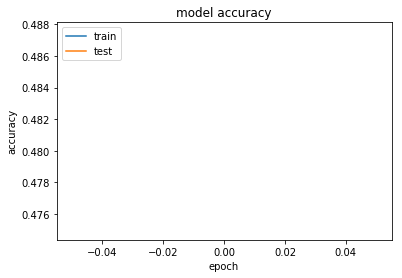

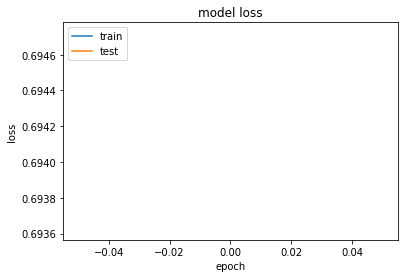

In [53]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

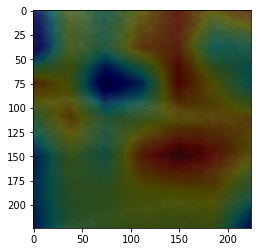

In [54]:
fig, ax = plt.subplots()

heatmap = generate_heatmap(model, "0001-0", image_processor)
original_image = image_processor.load_image("0001-0")

ax.imshow(original_image)
ax.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()